In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc3 as pm
import arviz as az

import theano
import theano.tensor as tt

sns.set_style("whitegrid")

## Распредделение Пуасона

Предположим, что мы подсчитываем количество красных машин, проезжающих по некоторой улице за один час. Для описания этих данных можно было бы воспользоваться распределением Пуассона. 

Распределение Пуассона применяется для описания вероятности определенного числа событий, возникающих в фиксированном временном или пространственном интервале. Таким образом, распределение Пуассона предполагает, что события происходят независимо друг от друга и возникают в строго определенном интервале времени и/или пространства. 

Это дискретное распределение параметризуется с использованием только одного значения $\mu$ (средняя частота возникновения событий, которую часто обозначают греческой буквой $\lambda$). Параметр $\mu$ соответствует среднему значению, а также дисперсии этого распределения. Функция вероятности распределения Пуассона определяется следующей формулой:
$$f(x|\mu)= \dfrac{\exp(-\mu)\mu^x}{x!}$$
где:
* $\mu$ – среднее арифметическое количества событий в единицу времени/пространства;
* x – положительное целое значение {0, 1, 2, ...};
* x! – факториал, то есть x! = 1×2×...×(x-1)×x.

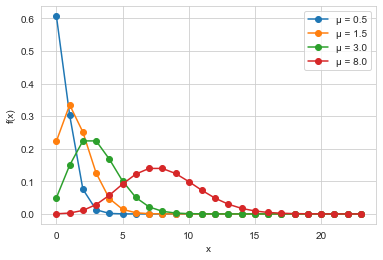

In [2]:
mu_params = [0.5, 1.5, 3, 8]
x = np.arange(0, max(mu_params) * 3) 
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}') 
plt.legend()
plt.xlabel('x') 
plt.ylabel('f(x)');

ВНИМАНИЕ! несмотря на то, что $\mu$ может быть числом с плавающей точкой, но выходные данные распределения Пуассона всегда являются целыми числами. 

НА схеме точки представляют значения этого распределения, в то время как непрерывные линии выполняют вспомогательную роль, помогая без затруднений узнать форму конкретного распределения. 

Следует всегда помнить о том, что распределение Пуассона – дискретное распределение.

Распределение Пуассона может рассматриваться как особый случай биномиального распределения, когда число испытаний $n$ весьма велико, но вероятность успешного исхода $p$ чрезвычайно мала. 

## Модель Пуассона с дополнительными нулевыми значениями

При подсчете объектов одним из возможных вариантов является отсутствие объекта счета, то есть получение нулевого значения. Ноль может встречаться по нескольким причинам: например, красные машины не проезжали по наблюдаемой улице или мы не заметили их (возможно, красная машина быстро проехала за большим грузовиком-трейлером). 

Поэтому при использовании распределения Пуассона вы заметите, например при выполнении проверки прогнозируемого апостериорного распределения, что модель генерирует меньше нулей по сравнению со значимыми данными. Как исправить эту ситуацию? 
Можно попытаться найти точную причину, по которой модель прогнозирует меньше нулей, чем наблюдается в действительности, и включить этот фактор в модель. Но чаще применяется вариант, при котором для наших целей достаточно просто предположить, что наблюдается смешанное выполнение двух процессов:
* процесс, моделируемый распределением Пуассона с вероятностью $\psi$
* процесс, генерирующий дополнительные нули с вероятностью $1-\psi$

Это модель Пуассона с дополнением нулевыми значениями (zero-inflated
Poisson – ZIP). В некоторых публикациях определяется, что $\psi$ представляет дополнительные нули, а $1-\psi$ – вероятность распределения Пуассона. Это несущественно, главное – помнить о том, что есть что, при решении конкретной задачи.

В общем виде модель Пуассона с дополнением нулевыми значениями выглядит так:
 $$ p(y_i=0) = (1- \psi) + \psi \exp(-\mu)$$
 $$ p(y_i = x_i) = \psi \dfrac{\exp(-\mu)\mu^x}{x_i!} $$
 
 Рассмотрим пример:

In [3]:
n = 500
θ_real = 2.5
ψ = 0.1

# Симуляция
counts = np.array([(np.random.random() > (1-ψ)) * 
                   np.random.poisson(θ_real) for i in range(n)])
counts

array([0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,

In [4]:
with pm.Model() as ZIP:
    ψ = pm.Beta('ψ', 1, 1)
    θ = pm.Gamma('θ', 3, 0.1)
    y = pm.ZeroInflatedPoisson('y', ψ, θ, observed=counts) 
    trace_zip = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [θ, ψ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 9 seconds.


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


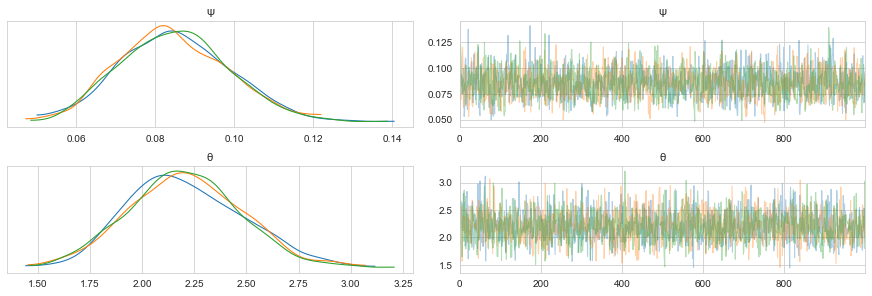

In [5]:
az.plot_trace(trace_zip);

In [6]:
az.summary(trace_zip)

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ψ,0.085,0.014,0.061,0.113,0.000,0.000,2162.0,2162.0,2111.0,1564.0,1.0
θ,2.209,0.273,1.696,2.698,0.005,0.004,2626.0,2606.0,2640.0,2335.0,1.0


Модель Пуассона с дополнением нулевыми значениями может показаться немного непонятной, но иногда необходимо давать оценку простым распределениям, таким как в приведенном выше примере, или таким как распределения Пуассона или нормальное. В любом случае, распределение Пуассона или модель Пуассона с дополнением нулевыми значениями можно использовать как часть линейной модели. 

Как уже наблюдалось при изучении логистической регрессии и softmax, можно воспользоваться функцией обратной связи для преобразования результата выполнения линейной модели в переменную с диапазоном значений, более подходящим для использования в других распределениях, отличающихся от нормального. 

Следуя этому принципу, теперь можно выполнять регрессионный анализ, когда выходная переменная представляет собой счетную (дискретную) переменную, и использовать для этого распределение Пуассона или модель Пуассона с дополнением нулевыми значениями. в качестве функции обратной связи можно взять экспоненциальную функцию. Такой выбор обеспечивает возврат из линейной модели только положительных значений:
$$ \theta = \exp(\alpha+ X\beta) $$


Выполним регрессионный анализ, когда выходная переменная представляет собой счетную (дискретную) переменную, и используем для этого распределение Пуассона или модель Пуассона с дополнением нулевыми значениями

Для примера реализации модели Пуассона с дополнением нулевыми значениями будем работать с набором данных, предоставляемым отделением кали- форнийского университета в Лос-Анджелесе Institute for Digital Research and Education (http://www.ats.ucla.edu/stat/data). Имеется 250 групп посетителей парка. Для каждой группы собраны некоторые фрагменты данных:

In [7]:
fish_data = pd.read_csv('fish.csv')
fish_data.head(5)

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


Нас будут интересовать только следующие столбцы:
* количество пойманных рыб (count);
* количество детей в группе (child);
* факт приезда в парк на туристическом автофургоне (camper)

Используя эти данные, создадим модель, прогнозирующую количество
пойманных рыб как функцию от переменных, определяющих количество детей и факт приезда в парк на туристическом автофургоне :)

In [8]:
fish_data[['child','camper']]

,child,camper
0,0,0
1,0,1
2,0,0
3,1,1
4,0,0
...,...,...
245,0,1
246,3,1
247,1,1
248,2,1


In [9]:
with pm.Model() as ZIP_reg:
    ψ = pm.Beta('ψ', 1, 1)
    α = pm.Normal('α', 0, 10)
    β = pm.Normal('β', 0, 10, shape=2)
    θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper']) 
    yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count']) 
    trace_ZIP_reg = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [β, α, ψ]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8877890454607575, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8937030882932135, but should be close to 0.8. Try to increase the number of tuning steps.


In [10]:
az.summary(trace_ZIP_reg)

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,1.611,0.085,1.448,1.765,0.002,0.002,1316.0,1316.0,1314.0,1706.0,1.0
β[0],-0.932,0.095,-1.096,-0.739,0.002,0.001,2307.0,2286.0,2319.0,1875.0,1.0
β[1],0.808,0.093,0.632,0.981,0.002,0.002,1389.0,1389.0,1386.0,1622.0,1.0
ψ,0.487,0.036,0.421,0.553,0.001,0.001,2419.0,2338.0,2430.0,1529.0,1.0


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


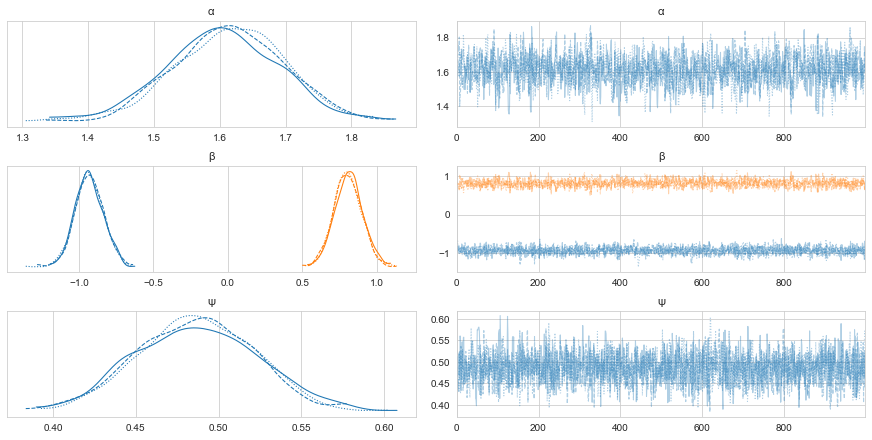

In [11]:
az.plot_trace(trace_ZIP_reg, compact = True);

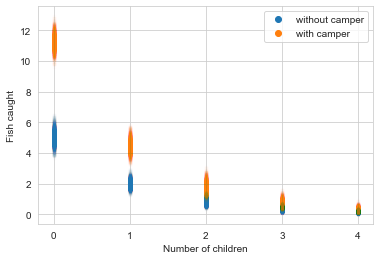

In [12]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
for n in children:
    without_camper = trace_ZIP_reg['α'] + trace_ZIP_reg['β'][:,0] * n
    with_camper = without_camper + trace_ZIP_reg['β'][:,1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))
    
    
plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend();

Очевидно, что чем больше количество детей, тем меньше поймано рыбы. Кроме того, прибывшие на собственном туристическом автофургоне в целом вылавливают больше рыбы. 
Если проверить коэффициенты $\beta$ для количества детей и наличия автофургона, то можно утверждать следующее:
* для каждого дополнительного ребенка ожидаемое количество пойманных рыб уменьшается на ≈ 0.4;
* наличие туристического автофургона увеличивает ожидаемое количество пойманных рыб на ≈ 2.

Эти значения получены при взятии экспоненты от коэффициентов $\beta_1$ и $\beta_2$ соответственно.

In [13]:
summary=az.summary(trace_ZIP_reg)
np.exp(summary['mean'].iloc[1:3])

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


β[0]    0.393765
β[1]    2.243417
Name: mean, dtype: float64

In [14]:
az.summary(trace_ZIP_reg)

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,1.611,0.085,1.448,1.765,0.002,0.002,1316.0,1316.0,1314.0,1706.0,1.0
β[0],-0.932,0.095,-1.096,-0.739,0.002,0.001,2307.0,2286.0,2319.0,1875.0,1.0
β[1],0.808,0.093,0.632,0.981,0.002,0.002,1389.0,1389.0,1386.0,1622.0,1.0
ψ,0.487,0.036,0.421,0.553,0.001,0.001,2419.0,2338.0,2430.0,1529.0,1.0
